2022-08-15 03:07:49,792 - PySpice.Spice.Netlist.Node - Netlist.WARNING - Node name 'in' is a Python keyword
------------------
Theoretical Values
------------------
VTH=2.63 V
RTH=8.25k Ω
IB=6.25u A
IC=1.87m A
IE=1.88m A
VCE=4.31 V
VC=6.19 V
VE=1.88 V
re=13.83 Ω
rpi=4.16k Ω
Rin=2.77k Ω
Ro=4.70k Ω
Avoc=-338.73
Av=-297.19


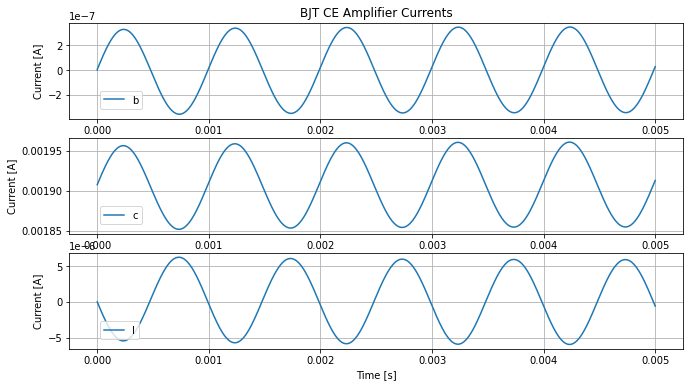

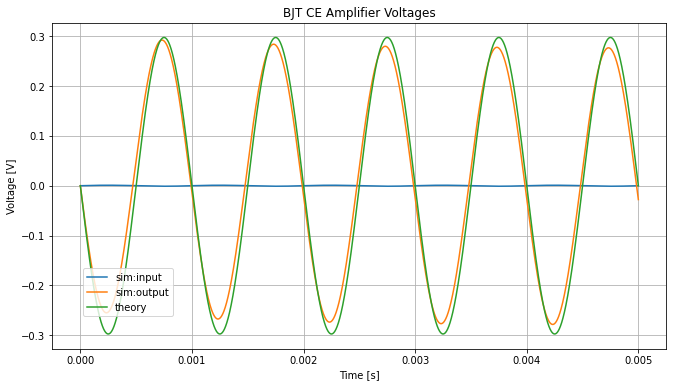

In [1]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
import numpy as np
from engineering_notation import EngNumber

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *


circuit = Circuit('BJT CE Amplifier')

amp=1@u_mV
freq=1@u_kHz
steptime=1@u_us
finaltime = 5@u_ms

# http://ltwiki.org/index.php?title=Standard.bjt

circuit.model('2N2222', 'npn', IS=1E-14, VAF=100, BF=200, IKF=0.3, XTB=1.5, BR=3,
              CJC=8E-12, CJE=25E-12, TR=100E-9, TF=400E-12, ITF=1,
              VTF=2, XTF=3, RB=10, RC=.3, RE=.2, VCEO=30)

circuit.model('2N3904', 'npn', IS=1E-14, VAF=100, Bf=300, IKF=0.4, XTB=1.5, BR=4,
              CJC=4E-12, CJE=8E-12, RB=20, RC=0.1, RE=0.1, TR=250E-9,
              TF=350E-12, ITF=1, VTF=2, XTF=3, VCEO=40)

source = circuit.SinusoidalVoltageSource(2, 'input', circuit.gnd, amplitude=amp, frequency = freq)

circuit.R('s', 'input','in',         100@u_Ω)
circuit.C(1,'in', 'base',            10@u_uF)
circuit.R('1', 'Vcc', 'base',        47@u_kΩ)
circuit.R('2', 'base', circuit.gnd,  10@u_kΩ)
circuit.R('C', 'Vcc', 'collector',    4.7@u_kΩ)
circuit.R('E', 'emitter', circuit.gnd,1@u_kΩ)
circuit.V(1, 'Vcc', circuit.gnd,      15@u_V)
circuit.BJT(1, 'collector', 'base', 'emitter', model='2N3904')
circuit.C(2,'collector', 'output',    10@u_uF)
circuit.C(3,'emitter', circuit.gnd, 100@u_uF)
circuit.R('L', 'output',circuit.gnd,  47@u_kΩ)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)

analysis = simulator.transient(step_time=steptime, end_time=finaltime)

i_b = ((analysis['input']-analysis['in'])/circuit.Rs.resistance)
+ ((analysis['Vcc']-analysis['base'])/circuit.R1.resistance)
+ ((-analysis['base'])/circuit.R2.resistance)
i_c=((analysis['Vcc']-analysis['collector'])/circuit.RC.resistance)-((-analysis['output'])/circuit.RL.resistance)
i_L = analysis['output']/circuit.RL.resistance


print('------------------')
print('Theoretical Values')
print('------------------')

beta=300
VBE = 0.7@u_V
VT =26@u_mV
# DC bias analysis
VTH = (circuit.V1.dc_value)*(circuit.R2.resistance/(circuit.R1.resistance+ circuit.R2.resistance))
RTH = (circuit.R1.resistance*circuit.R2.resistance)/(circuit.R1.resistance+ circuit.R2.resistance)
I_B = (VTH - VBE)/(RTH + (beta+1)*circuit.RE.resistance)
I_C = beta*I_B
I_E = (beta+1)*I_B
V_CE = (circuit.V1.dc_value)-(I_C*circuit.RC.resistance) - (I_E*circuit.RE.resistance)
V_C = (circuit.V1.dc_value)-(I_C*circuit.RC.resistance)
V_E = I_E*circuit.RE.resistance

# small signal AC analysis
r_e = (VT)/I_E
r_pi = (beta+1)*r_e
R_in = (RTH*r_pi)/(RTH + r_pi)
R_o = circuit.RC.resistance
A_voc = float(-R_o*beta/r_pi)
A_v = float(A_voc*(R_in/(R_in + circuit.Rs.resistance))*(circuit.RL.resistance/(circuit.RL.resistance+ R_o)))

time=np.array(analysis.time)
v_out = A_v*(amp)*(np.sin(2*np.pi*freq*time))


print('VTH={} V'.format(EngNumber(float(VTH))))
print('RTH={} Ω'.format(EngNumber(float(RTH))))
print('IB={} A'.format(EngNumber(float(I_B))))
print('IC={} A'.format(EngNumber(float(I_C))))
print('IE={} A'.format(EngNumber(float(I_E))))
print('VCE={} V'.format(EngNumber(float(V_CE))))
print('VC={} V'.format(EngNumber(float(V_C))))
print('VE={} V'.format(EngNumber(float(V_E))))
print('re={} Ω'.format(EngNumber(float(r_e))))
print('rpi={} Ω'.format(EngNumber(float(r_pi))))
print('Rin={} Ω'.format(EngNumber(float(R_in))))
print('Ro={} Ω'.format(EngNumber(float(R_o))))
print('Avoc={}'.format(EngNumber(float(A_voc))))
print('Av={}'.format(EngNumber(float(A_v))))

######################################################################

# ------------------------

figure, axe = plt.subplots(figsize=(11, 6))

axe = plt.subplot(311)
plt.title('BJT CE Amplifier Currents')
plt.ylabel('Current [A]')
plt.grid()
plot(i_b, axis=axe)
plt.legend(('base'), loc=(.05,.1))

axe = plt.subplot(312)
plt.ylabel('Current [A]')
plt.grid()
plot(i_c, axis=axe)
plt.legend('collector', loc=(.05,.1))

axe = plt.subplot(313)
plt.xlabel('Time [s]')
plt.ylabel('Current [A]')
plt.grid()
plot(i_L, axis=axe)
plt.legend('load current', loc=(.05,.1))

figure, axe = plt.subplots(figsize=(11, 6))

plt.title('BJT CE Amplifier Voltages')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plot(analysis['input'], axis=axe)
plot(analysis['output'], axis=axe)
plt.plot(time, v_out)
plt.legend(('sim:input', 'sim:output', 'theory'), loc=(.05,.1))
cursor = Cursor(axe, useblit=True, color='red', linewidth=1)

plt.show()
